In [1]:
# Uncomment to set up in Colab
#!pip install --quiet torchtyping
#!rm -rf bayesian-flow-networks
#!git clone https://github.com/javidlakha/bayesian-flow-networks.git

#import sys
#sys.path.append('bayesian-flow-networks')

In [2]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtyping import TensorType
from tqdm.auto import tqdm

from bfn import DiscreteBFN

In [3]:
def xor(
    batch_size: int,
    device: Optional[torch.device] = 'cpu',
) -> TensorType['batch', 'sequence']:
    """Returns a batch in which each element is either [0, 1] or [1, 0]"""
    x_0 = torch.randint(0, 2, size=(batch_size,), dtype=torch.bool)
    x_1 = ~x_0
    X = torch.stack([x_0, x_1], dim=1).long().to(device)
    return X

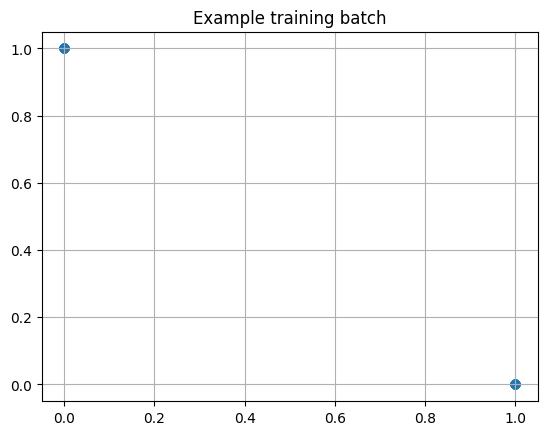

In [4]:
X = xor(128)
plt.title('Example training batch')
plt.scatter(X[:,0], X[:,1])
plt.grid()
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(
        self,
        sequence_len: int,
        vocab_size: int,
        hidden_dim: int,
    ) -> None:
        super().__init__()
        self.hidden = nn.Linear(sequence_len * vocab_size + 1, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, sequence_len * vocab_size)

    def forward(
        self,
        x: TensorType['batch', 'sequence', 'vocab'],
        t: TensorType['batch'],
        **kwargs,
    ) -> TensorType['batch', 'sequence', 'vocab']:
        batch_size, sequence_len, vocab_size = x.shape

        # Reshape to (batch_size, sequence_len * vocab_size)
        x = x.view(batch_size, -1)

        # Add time as a feature
        x = torch.cat((x, t[:, None]), dim=-1)

        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)

        # Reshape back to (batch_size, sequence_len, vocab_size)
        x = x.view(batch_size, sequence_len, vocab_size)

        return x

  0%|          | 0/4096 [00:00<?, ?it/s]

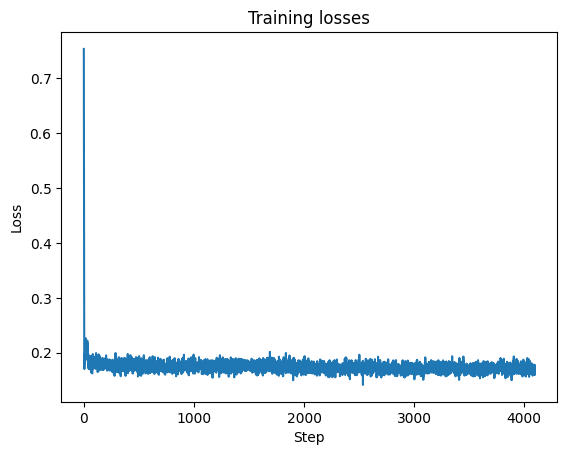

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sequence_len = 2
vocab_size = 2
batch_size = 2**12
hidden_dim = 16
training_steps = 2**12

net = Net(sequence_len, vocab_size, hidden_dim)
bfn = DiscreteBFN(sequence_len, vocab_size, net)
bfn.to(device)

optimiser = optim.AdamW(bfn.parameters(), lr=1e-1)

losses = []
for i in tqdm(range(training_steps)):
    optimiser.zero_grad()
    batch = xor(batch_size, device)
    loss = bfn.continuous_time_loss(batch)
    loss.backward()
    optimiser.step()
    losses.append(loss.detach().item())

plt.title('Training losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

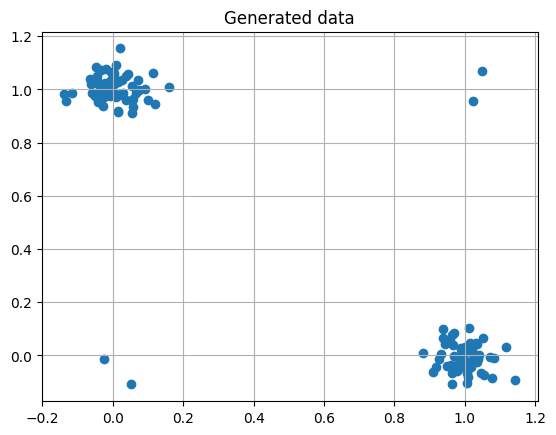

In [7]:
X = bfn.generate(
    batch_size=128,
    steps=4,
    device=device,
).cpu().numpy()

# Add some noise to make the data visible
X = X + (np.random.randn(*X.shape) * 0.05)

plt.title('Generated data')
plt.scatter(X[:,0], X[:,1])
plt.grid()
plt.show()